<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/Develop/ClassificadorXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais


<center>
<table><tr><td> <a href="http://www.minds.eng.ufmg.br/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/minds_logo_medium.jpeg" alt="MINDS - Machine Intelligence and Data Science Lab" width="100"/></a></td> 
  <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
<td><a href="https://pyfts.github.io/pyFTS/"><img src="https://github.com/petroniocandido/pyFTS/raw/master/img/logo_medium.png" alt="pyFTS - Fuzzy Time Series for Python" width="100"/></a></td>
</tr>
</table>
</center>

In [1]:
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U pyFTS
!pip3 install SimpSOM
!pip install dispy
#!pip install matplotlib==3.1.3

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

## Analisando as Séries Temporais

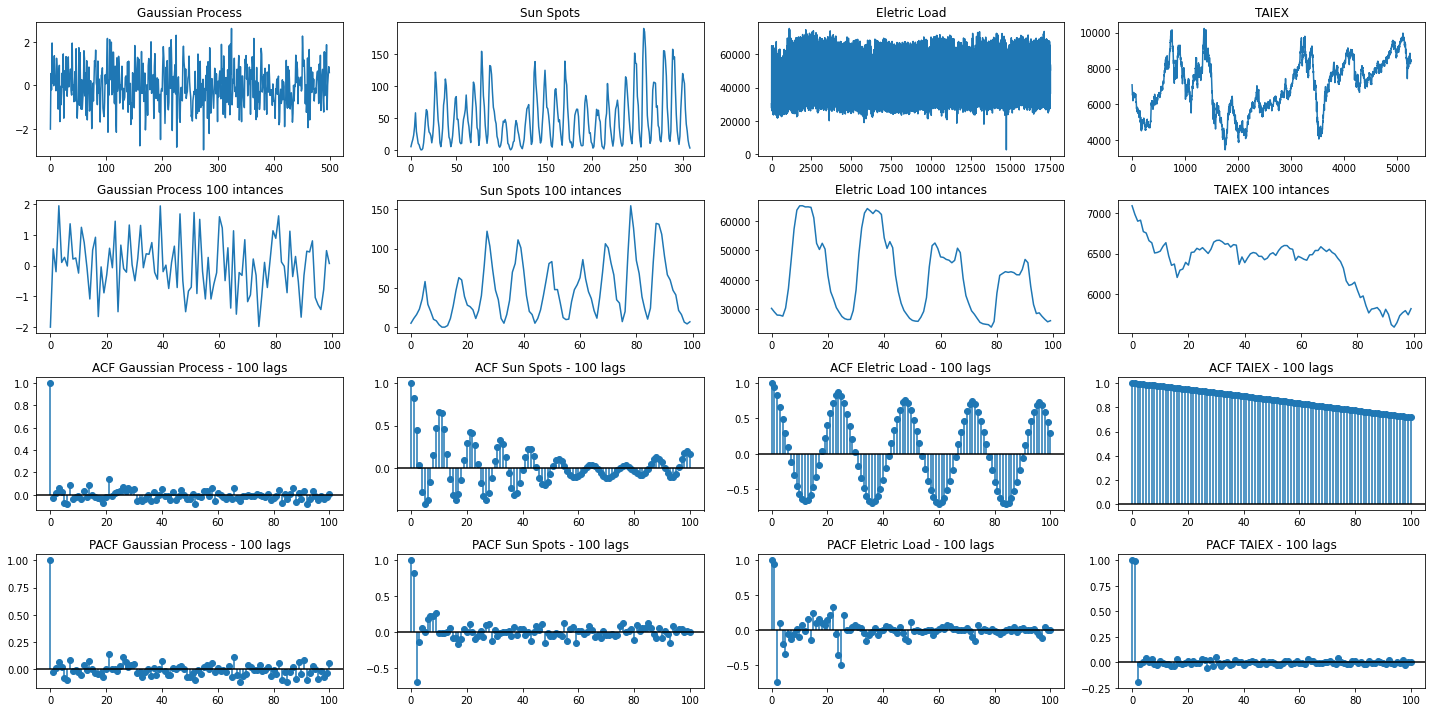

In [4]:
from pyFTS.data import TAIEX, Malaysia, sunspots, artificial
from statsmodels.tsa.stattools import acf, pacf

datasets = {}

datasets['Gaussian Process'] = artificial.white_noise()
datasets['Sun Spots'] = sunspots.get_data()
datasets['Eletric Load'] = Malaysia.get_data('load')
datasets['TAIEX'] = TAIEX.get_data()
#datasets['Temperature'] = Malaysia.get_data('temperature')


fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[20,10])

for ct, (key, data) in enumerate(datasets.items()): 
  _lags = np.arange(0,101)
  _acf = acf(data,nlags=100)
  _pacf = pacf(data,nlags=100)
  
  ax[0][ct].set_title("{}".format(key))
  ax[0][ct].plot(data)
  
  ax[1][ct].set_title("{} 100 intances".format(key))
  ax[1][ct].plot(data[:100])
  
  ax[2][ct].set_title("ACF {} - 100 lags".format(key))
  ax[2][ct].plot(_lags, _acf, "o")
  ax[2][ct].vlines(_lags,[0],_acf)
  ax[2][ct].axhline(y=0, color='black')
  
  ax[3][ct].set_title("PACF {} - 100 lags".format(key))
  ax[3][ct].plot(_lags, _pacf, "o")
  ax[3][ct].vlines(_lags,[0],_pacf)
  ax[3][ct].axhline(y=0, color='black')

plt.tight_layout()

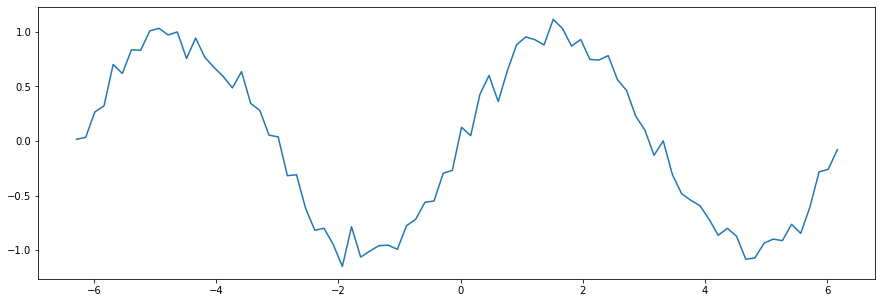

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

x = [k for k in np.arange(-2*np.pi, 2*np.pi, 0.15)] 
l = len(x)
y = [np.sin(k) for k in x]
y += np.random.normal(0, 0.1, l)

ax.plot(x, y)

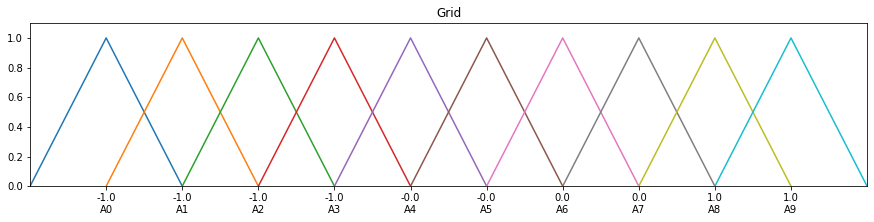

In [8]:
from pyFTS.data import Enrollments
from pyFTS.partitioners import Grid
from pyFTS.models import hofts

dados_treino = y[:60] 

dados_teste = y[60:]

#Particionamento do Universo de Discurso
particionador = Grid.GridPartitioner(data=dados_treino,npart=10, freq = 1)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])

particionador.plot(ax)


,Partitions,RMSE,MAPE,U
0,Grid,0.14,54.31,0.78
1,Entropy,0.15,153.90,0.85
2,FCM,0.14,91.55,0.80
3,CMeans,0.13,34.33,0.73


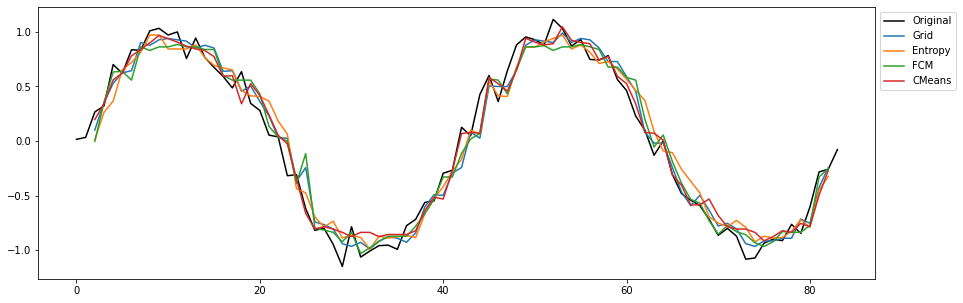

In [9]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid, FCM, CMeans, Entropy
from pyFTS.benchmarks import Measures

metodos = [Grid.GridPartitioner, Entropy.EntropyPartitioner, FCM.FCMPartitioner, CMeans.CMeansPartitioner ]

k = 25

rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(y, label='Original',color='black')

for contador, metodo in enumerate(metodos):
  part = metodo(data=y, npart=k)
  model = hofts.HighOrderFTS(order=2, partitioner=part)
  model.fit(y)
  forecasts = model.predict(y)
  for o in range(model.order):
    forecasts.insert(0,None)
    
  ax.plot(forecasts[:-1], label=part.name)
  
  rmse, mape, u = Measures.get_point_statistics(y, model)
  
  rows.append([part.name, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

In [10]:
from pyFTS.models import chen, cheng, hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures

metodos = [chen.ConventionalFTS, cheng.TrendWeightedFTS, hofts.HighOrderFTS, 
          hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]

k = 15

part = Grid.GridPartitioner(data=y, npart=k)

for contador, metodo in enumerate(metodos):
  model = metodo(partitioner=part)
  if model.is_high_order:
    model = metodo(partitioner=part, order=2)
  model.fit(y)
  print(model)

Conventional FTS:
A2 -> A1,A2,A3
A1 -> A1,A2,A3
A3 -> A1,A2,A3,A4
A5 -> A4
A4 -> A3,A4,A6
A6 -> A4,A5,A6,A7,A8
A8 -> A10,A6,A7,A8,A9
A7 -> A8
A9 -> A10,A8
A10 -> A11,A12,A9
A11 -> A10,A11,A13
A12 -> A11,A12,A13
A13 -> A12,A13,A14
A14 -> A12,A13,A14

Trend Weighted FTS:
A1 -> A1(0.1),A2(0.2),A2(0.3),A3(0.4)
A2 -> A1(0.018),A1(0.036),A2(0.055),A2(0.073),A2(0.091),A2(0.109),A2(0.127),A3(0.145),A3(0.164),A3(0.182)
A3 -> A1(0.022),A2(0.044),A2(0.067),A2(0.089),A3(0.111),A3(0.133),A3(0.156),A4(0.178),A4(0.2)
A5 -> A4(1.0)
A4 -> A3(0.048),A3(0.095),A4(0.143),A4(0.19),A6(0.238),A6(0.286)
A6 -> A4(0.036),A5(0.071),A6(0.107),A6(0.143),A6(0.179),A7(0.214),A8(0.25)
A8 -> A10(0.028),A6(0.056),A6(0.083),A7(0.111),A8(0.139),A8(0.167),A8(0.194),A9(0.222)
A7 -> A8(1.0)
A9 -> A10(0.167),A8(0.333),A8(0.5)
A10 -> A11(0.067),A11(0.133),A12(0.2),A9(0.267),A9(0.333)
A11 -> A10(0.036),A10(0.071),A10(0.107),A11(0.143),A11(0.179),A13(0.214),A13(0.25)
A12 -> A11(0.036),A11(0.071),A11(0.107),A12(0.143),A12(0.179)

In [ ]:
dataset = pd.read_excel('../content/sample_data/Base.xlsx')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

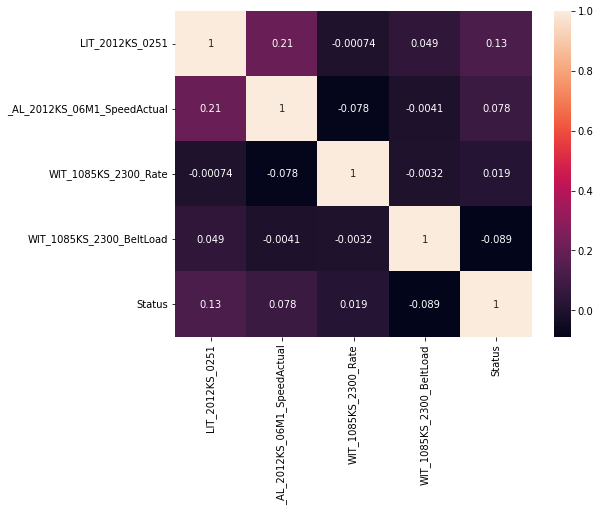

In [ ]:
import seaborn as sns
dataset2 = pd.read_excel('../content/sample_data/Base.xlsx')
corr_df = dataset2.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
print(dataset2)

      LIT_2012KS_0251  ...  Status
0           25.444870  ...       1
1           24.390213  ...       1
2           22.518898  ...       1
3           30.281023  ...       1
4           48.265495  ...       1
...               ...  ...     ...
6313         2.114453  ...       0
6314         2.566652  ...       0
6315         3.876476  ...       0
6316         3.395008  ...       0
6317         3.202985  ...       0

[6318 rows x 5 columns]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 10)

In [ ]:
from xgboost import XGBClassifier
Classifier = XGBClassifier()
Classifier.fit(x_train, y_train)

XGBClassifier()

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
ypred = Classifier.predict(x_test)
cm = confusion_matrix(y_test, ypred)
print(cm)

[[281 197]
 [ 65 721]]


Precisão

In [ ]:
accuracy_score(y_test, ypred)

0.7927215189873418

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Classifier, X = x_train, y = y_train, cv = 10)

print(accuracies.mean()*100)
print(accuracies.std()*100)

79.20349861073063
1.6023111356796393
